In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
df = pd.read_csv('wt.csv')

# remove spaces in columns name
df.columns = df.columns.str.replace(' ','_')

# splitting two WT in different dataset using location of turbine
grouped = df.groupby(df.unitlocation)
wtg40 = grouped.get_group("WTG40")

# get failure times
fault_time_wtg40 = wtg40.failure_time.unique()

# get the failure status in dataset
wtg40['total_runtime'] = [i*10 for i in range(1,len(wtg40)+1)]
wtg40['is_fault'] = wtg40['total_runtime']< fault_time_wtg40.max()

# remove some columns that are unnecessary
df = wtg40.drop(['unitlocation', 'ttimestamplocal','total_runtime', 'failure_time'], axis=1)

df['is_fault'] = df['is_fault'].astype('category')
df['is_fault'] = df['is_fault'].cat.codes

# final datasets for training
y = df['is_fault']
x= df.drop(['is_fault'],  axis=1)
x.describe()

,windspeed,power,wind_direction_Angle,rtr_rpm,pitch_Angle,generation,wheel_hub_temperature,ambient_Temperature,Tower_bottom_ambient_temperature
count,42592.000000,42592.000000,42592.000000,42592.000000,42592.000000,4.259200e+04,42592.000000,42592.000000,42592.000000
mean,4.693273,653.797555,171.081463,7.227109,8.868844,5.665854e+06,22.785580,15.840264,29.088985
std,2.770764,739.499557,48.802821,3.840320,21.170777,1.233734e+06,8.086884,9.347388,6.523025
min,0.020000,-29.840000,0.000000,0.210000,-0.580000,2.872434e+06,-4.830000,-13.060000,2.960000
25%,2.680000,60.047500,175.170000,5.000000,-0.520000,4.843144e+06,17.590000,9.950000,25.087500
50%,4.300000,323.215000,180.520000,7.120000,-0.500000,5.916913e+06,23.820000,17.280000,30.310000
75%,6.372500,1056.462500,185.160000,10.540000,1.950000,6.577421e+06,29.562500,23.180000,33.890000
max,19.210000,2224.870000,355.970000,12.480000,90.470000,7.529655e+06,37.210000,36.210000,44.830000


In [3]:
# check there is any null value present in dataset or not
print(x.isnull().values.any())
# 1 -> outlier  and 0-> normal
y

False


0        1
1        1
2        1
3        1
4        1
        ..
42587    0
42588    0
42589    0
42590    0
42591    0
Name: is_fault, Length: 42592, dtype: int8

In [4]:
# Apply PCA to reduce dimensionality reduction
fatures_name = x.columns.tolist()
x_std = StandardScaler().fit_transform(x)
x_std = pd.DataFrame(x_std,columns= fatures_name)
x_std.head(5)

,windspeed,power,wind_direction_Angle,rtr_rpm,pitch_Angle,generation,wheel_hub_temperature,ambient_Temperature,Tower_bottom_ambient_temperature
0,-1.358224,-0.884118,-3.505606,-1.782974,1.942377,-2.264226,-1.514270,-1.397226,-1.485369
1,-1.401533,-0.884118,-3.505606,-1.785578,1.942377,-2.264226,-1.506850,-1.395087,-1.534427
2,-1.491762,-0.884118,-3.505606,-1.788182,1.942377,-2.264226,-1.467279,-1.399366,-1.494567
3,-1.527854,-0.884118,-3.505606,-1.788182,1.942377,-2.264226,-1.500667,-1.403645,-1.497633
4,-1.531463,-0.884118,-3.505606,-1.795994,1.942377,-2.264226,-1.504377,-1.392947,-1.517563


How to select numbers of components?

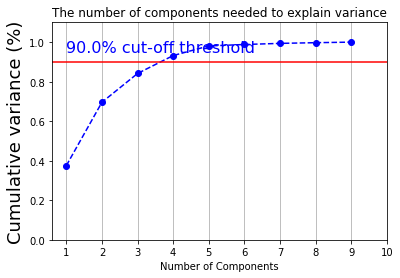

In [7]:
# https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
pca_ = PCA().fit(x_std)
desired_variance = 0.90
fig, ax = plt.subplots()
yi = np.cumsum(pca_.explained_variance_ratio_)
xi = np.arange(1, yi.shape[0]+1, step=1)
plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, yi.shape[0]+2, step=1))
plt.ylabel('Cumulative variance (%)', fontsize=18)
plt.title('The number of components needed to explain variance')
plt.axhline(y=desired_variance, color='r', linestyle='-')
plt.text(1, desired_variance+ 0.05, str(desired_variance*100) +'% cut-off threshold', color='b', fontsize=16)
ax.grid(axis='x')
plt.show()

In [8]:
# from above figure to acheive 0.95 explained varience we need 5 components
pca = PCA(n_components=2)
X = pca.fit_transform(x_std)
X

array([[-0.35104603,  2.97913512],
       [-0.36204073,  3.01016619],
       [-0.42436286,  2.99481883],
       ...,
       [ 4.44375194,  2.82710526],
       [ 4.4187954 ,  2.82486931],
       [ 4.39452195,  2.86047325]])

In [9]:
# variance ratio of each components
pca.explained_variance_ratio_

array([0.37528614, 0.32053537])

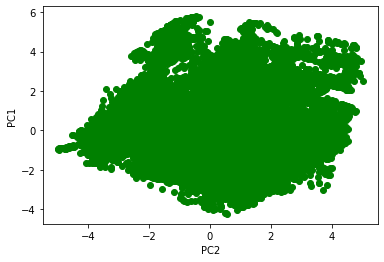

In [11]:
plt.scatter(X[:,0], X[:,1], color='green')
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.show()

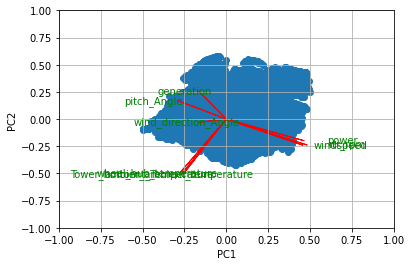

In [12]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs*scalex, ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r')
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'r', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.5, coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
myplot(X[:,0:2],np.transpose(pca.components_[0:2, :]),fatures_name)
plt.show()

In [13]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis/50845697#50845697

# number of components
n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [fatures_name[most_important[i]] for i in range(n_pcs)]
most_important_names

['rtr_rpm', 'Tower_bottom_ambient_temperature']

In [14]:
# splitting testing and training set
X_train =X[:35000]
X_test = X[35000:42592]
y_train = y[:35000]
y_test = y[35000:42592]

In [15]:
# fit the model for hyper parameter tunning
clf = OneClassSVM(nu=0.25, gamma=0.35)
clf.fit(X_train)

OneClassSVM(gamma=0.35, nu=0.25)

In [16]:
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-3, high=3, size=(10, 2))

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# error 
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

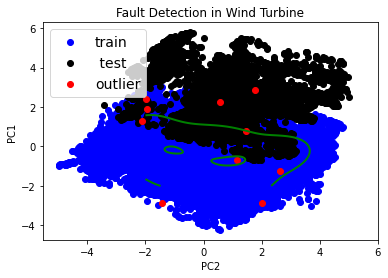

In [17]:
# plot the result in two dimensional space
# this part of code will not work if you dont use PCA
xx, yy = np.meshgrid(np.linspace(-2, 6, 500), np.linspace(-2, 4, 500))
plt.figure(1)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend1 = {}
legend1["boundry"] = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='green')
legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())
plt.figure(1)  
plt.title("Fault Detection in Wind Turbine")
plt.scatter(X_train[:, 0], X_train[:, 1], color='blue')
plt.scatter(X_test[:, 0], X_test[:, 1], color='black')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], color='red')
#plt.xlim((xx.min(), xx.max()))
#plt.ylim((yy.min(), yy.max()))
plt.legend([legend1_values_list[0].collections[0]],     
           labels= ["train"," test",'outlier'],
           loc="best",
           prop=matplotlib.font_manager.FontProperties(size=14))
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.show()

In [19]:
clf.get_params(deep=True)

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 0.35,
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.25,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}